### Environment Setup

In [1]:
# Basics
import numpy as np
import pandas as pd
import string
import re

# Natural Language Toolkit for Cleaning and Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

### Explore Dataset

In [2]:
train_df = pd.read_csv('Data/Kaggle NLP/train.csv')
test_df = pd.read_csv('Data/Kaggle NLP/test.csv')

In [3]:
# Taking a peek...
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
# Taking a peek...
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [5]:
# These are all the ones that are not disaster tweets
train_df[train_df['target'] == 0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


In [6]:
# This is an example of one tweet that is non disaster related
train_df[train_df['target'] == 0]['text'].values[1]

'I love fruits'

In [7]:
# This is the an example of a disaster tweet
train_df[train_df['target'] == 1]['text'].values[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

#### Cleaning the Data

The checklist to clean the data is:
- Remove all irrelevant characters
- Tokenize text
- Remove irrelevant words
- Convert all words into lowercase
- Consider combining misspellings of words into a single representation
- Consider lemmatization

In [8]:
# Disaster Tweet Texts
train_df[train_df['target'] == 1]['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

In [9]:
# Non Disaster Tweet Texts
train_df[train_df['target'] == 0]['text']

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

In [10]:
# Checking whether we need all these columns...
# How many null values are there in the columns here?
print(f" There are {train_df['keyword'].isnull().sum()} NaN values in the keyword column of the dataframe out of {train_df['keyword'].count()}")
print(f" There are {train_df['location'].isnull().sum()} NaN values in the location column of the dataframe out of {train_df['location'].count()}")
print(f" There are {train_df['text'].isnull().sum()} NaN values in the text column of the dataframe out of {train_df['text'].count()}")

 There are 61 NaN values in the keyword column of the dataframe out of 7552
 There are 2533 NaN values in the location column of the dataframe out of 5080
 There are 0 NaN values in the text column of the dataframe out of 7613


In [11]:
# How many unique inputs are there in the columns?
# I'm using len() because just listing it will be a long list, the length of the list is the number of unique inputs in the list itself which is more what i need
len(train_df['keyword'].unique().tolist())

222

In [12]:
# What is the class balance in this dataset?
train_df.groupby('target').count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


There is a slight oversampling of the non-disaster tweets, but all in all not bad.

In [13]:
# Lets remove the location and the keyword columns and keep just the text; this way we can make sure just the relevant information is available, which is the content of the tweet itself.
del train_df['keyword']
del train_df['location']

In [14]:
# How does it look like now?
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


This is perfect. I just have the target column, which is the label, and the tweet text. I can further clean this data now and make the text itself more uniform before fitting it into models.

#### Data Preprocessing

To make the data more usable, I want to remove the punctuation marks, numbers, make all characters lowercase, and separate the words in each comment.
This is to make sure that the model works solely on the content words of the tweets themselves to determine what is a disaster tweet versus not, and not other syntaxtical expressions.

In [15]:
# Using string replace in the column of the tweets to remove the numbers first.
train_df['text'] = train_df['text'].str.replace('\d+', '')
train_df['text'].head(10)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    , people receive #wildfires evacuation orders ...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy.  closed i...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [16]:
# A normal function to remove punctuation
def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

In [17]:
# Let's try out the function...
train_df['text'] = train_df['text'].apply(lambda x: remove_punctuation(x))
train_df['text'].head(10)

0    Our Deeds are the Reason of this earthquake Ma...
1                Forest fire near La Ronge Sask Canada
2    All residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    Just got sent this photo from Ruby Alaska as s...
5    RockyFire Update  California Hwy  closed in bo...
6    flood disaster Heavy rain causes flash floodin...
7    Im on top of the hill and I can see a fire in ...
8    Theres an emergency evacuation happening now i...
9     Im afraid that the tornado is coming to our area
Name: text, dtype: object

In [18]:
# Check if this changed the dataframe...
train_df.head(10)

,id,text,target
0,1,Our Deeds are the Reason of this earthquake Ma...,1
1,4,Forest fire near La Ronge Sask Canada,1
2,5,All residents asked to shelter in place are be...,1
3,6,people receive wildfires evacuation orders in...,1
4,7,Just got sent this photo from Ruby Alaska as s...,1
5,8,RockyFire Update California Hwy closed in bo...,1
6,10,flood disaster Heavy rain causes flash floodin...,1
7,13,Im on top of the hill and I can see a fire in ...,1
8,14,Theres an emergency evacuation happening now i...,1
9,15,Im afraid that the tornado is coming to our area,1


Okay, so all the punctuation has been removed that was present before, like the hashtags, etc.

Now, we can tokenize the dataframe to separate the sentences in each tweet into individual words.

In [19]:
# Instantiate the tokenizer we will use
tokenizer = RegexpTokenizer(r'\w+')

In [20]:
# We can use RegEx to remove punctuation AND convert the text to all lower case at the same time.
# Lambda functions DO NOT update INPLACE, so i have to set the value of the column I'm changing to the result of the lambda function or else it won't actually change the dataframe
train_df['text'] = train_df['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
train_df.head(10)

,id,text,target
0,1,"[our, deeds, are, the, reason, of, this, earth...",1
1,4,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,"[all, residents, asked, to, shelter, in, place...",1
3,6,"[people, receive, wildfires, evacuation, order...",1
4,7,"[just, got, sent, this, photo, from, ruby, ala...",1
5,8,"[rockyfire, update, california, hwy, closed, i...",1
6,10,"[flood, disaster, heavy, rain, causes, flash, ...",1
7,13,"[im, on, top, of, the, hill, and, i, can, see,...",1
8,14,"[theres, an, emergency, evacuation, happening,...",1
9,15,"[im, afraid, that, the, tornado, is, coming, t...",1


Now, we remove stop words from the dataframe as the next step in preprocessing.

In [21]:
# We write a function that will remove the stop words using the nltk package we imported.
# This will remove words in the text we place in the function if the word is in the list of english stopwords, else, ignore the word
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [22]:
# First, I check that the lambda function is doing what I wanted before I make the dataframe changes in place.
train_df['text'].apply(lambda x : remove_stopwords(x))

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610           [utckm, volcano, hawaii, httptcozdtoydebj]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [23]:
# It all looks good, so I update the dataframe.
train_df['text'] = train_df['text'].apply(lambda x : remove_stopwords(x))
train_df['text'].head(10)

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
5    [rockyfire, update, california, hwy, closed, d...
6    [flood, disaster, heavy, rain, causes, flash, ...
7                    [im, top, hill, see, fire, woods]
8    [theres, emergency, evacuation, happening, bui...
9                  [im, afraid, tornado, coming, area]
Name: text, dtype: object

Next up, lemmatization.
This will map out common words that have the same meaning, and use the base word to retain the same meaning but reduce the overall number of words in the tweet.

Basically, it simplifies the tweet while retaining the meaning, making it simpler to model.

In [24]:
# First, we instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [25]:
# Next, we create a function that will lemmatize the text in the tweets
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [26]:
# Now we apply this function to our dataset...
train_df['text'].apply(lambda x : word_lemmatizer(x))
train_df['text'].head(10)

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
5    [rockyfire, update, california, hwy, closed, d...
6    [flood, disaster, heavy, rain, causes, flash, ...
7                    [im, top, hill, see, fire, woods]
8    [theres, emergency, evacuation, happening, bui...
9                  [im, afraid, tornado, coming, area]
Name: text, dtype: object

In [27]:
# Finally, let's remove all the left over 's  characters that linger after punctuation is removed.
train_df['text'] = train_df['text'].apply(lambda x: str(x).replace(" s ", " "))

In [28]:
train_df.head(10)

,id,text,target
0,1,"['deeds', 'reason', 'earthquake', 'may', 'alla...",1
1,4,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...",1
2,5,"['residents', 'asked', 'shelter', 'place', 'no...",1
3,6,"['people', 'receive', 'wildfires', 'evacuation...",1
4,7,"['got', 'sent', 'photo', 'ruby', 'alaska', 'sm...",1
5,8,"['rockyfire', 'update', 'california', 'hwy', '...",1
6,10,"['flood', 'disaster', 'heavy', 'rain', 'causes...",1
7,13,"['im', 'top', 'hill', 'see', 'fire', 'woods']",1
8,14,"['theres', 'emergency', 'evacuation', 'happeni...",1
9,15,"['im', 'afraid', 'tornado', 'coming', 'area']",1


In [29]:
# Now, how many words are we dealing with in the end?
print(f" We have {train_df['text'].str.split().str.len().sum()} words that will need to be processed by our NLP model.")

 We have 74850 words that will need to be processed by our NLP model.


A single function can also be written for future NLP projects to do the preprocessing steps in order, given a dataframe.

In [30]:
# All DF Text Column Preprocessing Code:

#train_df['text'] = train_df['text'].str.replace('\d+', '')
#def remove_punctuation(text):
#    no_punct = "".join([c for c in text if c not in string.punctuation])
#    return no_punct
#train_df['text'] = train_df['text'].apply(lambda x: remove_punctuation(x))
#tokenizer = RegexpTokenizer(r'\w+')
#train_df['text'] = train_df['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
#def remove_stopwords(text):
#    words = [w for w in text if w not in stopwords.words('english')]
#    return words
#train_df['text'].apply(lambda x : remove_stopwords(x))
#train_df['text'] = train_df['text'].apply(lambda x : remove_stopwords(x))
#lemmatizer = WordNetLemmatizer()
#def word_lemmatizer(text):
#    lem_text = [lemmatizer.lemmatize(i) for i in text]
#    return lem_text
#train_df['text'].apply(lambda x : word_lemmatizer(x))
#train_df['text'] = train_df['text'].apply(lambda x: str(x).replace(" s ", " "))

The data is now preprocessed.

The next step is to see which models are most appropriate to use.

#### NLP Models

In [45]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm, feature_extraction, model_selection
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

Because we have roughly 75,000 words, and roughly 7800 tweets, there isn't too much data to work with. Using TF-IDF to Vectorize the data, and using SVM on that transformed data would be a good place to start.

In [32]:
# We need to split the data into training and testing data.
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_df['text'],
                                                    train_df['target'],
                                                    test_size = 0.33,
                                                    random_state = 20)

In [33]:
# Now, we need to vectorize the data to make it usable in a model
tfidf_vect = feature_extraction.text.TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [34]:
# The model we will use is SVM, so let's instantiate the model
svm = SVC(probability = True, kernel = 'rbf', gamma = 'auto')

In [35]:
# Fit that model
svm.fit(X_train_tfidf, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [36]:
# Predict for a test
predictions_SVM = svm.predict(X_test_tfidf)
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  57.739753282928774


Without any hyperparameter optimizations, we got a score of 57.7% with SVM and TF-IDF Vectors.

Let's improve the score...

In [37]:
# I want to see which kernel seems to perform best for the dataset
validation_scores = []
train_scores = []

# Different kernels to try...
kernels = ['rbf', 'linear', 'poly']
# And different C values as well...

# Let's try tuning these hyperparamters to see how that affects the performance.
for kernel in kernels:
    svm = SVC(probability = True, kernel = kernel, gamma = 'auto')
    svm.fit(X_train_tfidf,y_train)
    predictions = svm.predict(X_test_tfidf)
    
    # score on traning set
    train_scores.append(svm.score(X_train_tfidf,y_train))
    # score on validation set
    validation_scores.append(accuracy_score(predictions, y_test))

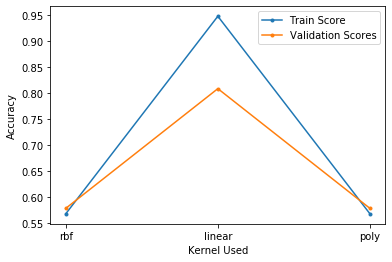

In [38]:
# Graphing the results
plt.figure()
plt.plot(kernels, train_scores, label="Train Score", marker='.')
plt.plot(kernels, validation_scores, label="Validation Scores", marker='.')
plt.xlabel('Kernel Used')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

The linear kernel seemed to have worked best with the default values.

Let's try using that kernel and altering the C values to see which performs best.

In [39]:
# I want to graph the different values, so lists have to made that will be appended upon testing.
validation_scores = []
train_scores = []

# Let's try different 'C' values, different 'kernels', and see what works best.
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    svm = SVC(probability = True, kernel = 'linear', gamma = 'auto', C = c)
    svm.fit(X_train_tfidf,y_train)
    predictions = svm.predict(X_test_tfidf)
    
    # score on traning set
    train_scores.append(svm.score(X_train_tfidf,y_train))
    # score on validation set
    validation_scores.append(accuracy_score(predictions, y_test))
    # validation_scores.append(svm.score(X_test_tfidf,y_test))

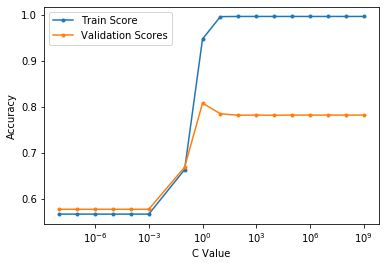

In [40]:
# Graphing the results
plt.figure()
plt.plot(C_range, train_scores, label="Train Score", marker='.')
plt.plot(C_range, validation_scores, label="Validation Scores", marker='.')
plt.xscale('log')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [41]:
# What were the accuracy scores at different c values?
validation_scores

[0.5773975328292877,
 0.5773975328292877,
 0.5773975328292877,
 0.5773975328292877,
 0.5773975328292877,
 0.5773975328292877,
 0.6689216076402706,
 0.807799442896936,
 0.7847194588141664,
 0.7815360127337844,
 0.781933943493832,
 0.7815360127337844,
 0.781933943493832,
 0.781933943493832,
 0.781933943493832,
 0.781933943493832,
 0.781933943493832]

With a bit of hyperparameter optimization, we have found that a C Value = 10 performed best with the linear kernel.
We were able to improve the score of the SVM model from 57.7% to  80.7%.

There is a more methodical way of doing this using a GridSearch to tune the parameters until we find one that works best. We don't know yet how the other kernels perform at different C values, so maybe they perform better than this setup at values we have yet to explore.

In [52]:
# We choose the model we want, which is svm, and then fill out the grid search code
# First, we need our parameter grid dictionary, which will be used to tune the model
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid'],
              'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 100, 1000, 10000, 100000],
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
              'gamma': ['scale', 'auto']}

model = SVC()
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=5, scoring='accuracy', refit=True, verbose=10, n_jobs=-1)

# Fit the grid search with the dataset.
grid.fit(X_train_tfidf, y_train)

# Check the  best parameters found
print(grid.best_params_)
grid_predictions = grid.predict(X_test_tfidf)

# Finally, a classification report...
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 66 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1451
           1       0.81      0.71      0.76      1062

    accuracy                           0.81      2513
   macro avg       0.81      0.80      0.80      2513
weighted avg       0.81      0.81      0.81      2513



It seems that sticking with the SVC model, we have peaked at 81% accuracy with a C-Value=1, Gamma=Auto, and Kernel=Linear.
We can try different preprocessing methods maybe to see if we could improve how the data is represented to the model as a way to further enhance the models ability; however, 81% from 57% is not bad with just hyperparameter tuning!